In [1]:
# This cell imports all the necessary libraries
!pip install ordpy
import numpy as np
import ordpy
from ordpy import renyi_entropy
from ordpy import permutation_entropy
from ordpy import renyi_complexity_entropy
from ordpy import minimum_complexity_entropy
from ordpy import maximum_complexity_entropy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import string
import glob
import warnings
import math
from scipy.fft import fft, ifft
from scipy.io import savemat
import matplotlib.colors as mcolors


In [2]:
def maximum_renyi_complexity_entropy(dx=3, dy=1, m=1, q=1.4):
    """
    Generates data corresponding to values of normalized renyi permutation
    entropy and statistical complexity which delimit the upper boundary in the
    complexity-entropy renyi causality plane\\ [#rosso_curvas]_:sup:`,`\\ [*]_.

    Parameters
    ----------
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    dy : int
         Embedding dimension (vertical axis); must be 1 for time series
         (default: 1).
    m : int
        The length of the returned array containing values of permutation entropy
        and statistical complexity is given by
        :math:`[(d_x \\times d_y)!-1] \\times m`.
    q:  float
        Renyi parameter (default: 1.4)

    Returns
    -------
     : array
       Values of normalized permutation renyi entropy and statistical complexity
       belonging to the upper limiting curve of the renyi complexity-entropy causality
       plane.

    Notes
    -----
    .. [*] This function was adapted from Ordpy.

    """
    if q==1.0:
       return maximum_complexity_entropy(dx,dy,m)
    else:
       N              = math.factorial(dx*dy)
       hlist_, clist_ = np.zeros(shape=(N-1,m)), np.zeros(shape=(N-1,m))
       for i in range(N-1):
           p             = np.zeros(shape=N)
           uniform_dist  = np.full(N, 1/N)
           prob_params   = np.linspace(0, 1/N, num=m)
           for k in range(len(prob_params)):
               p[0] = prob_params[k]
               for j in range(1,N-i):
                   p[j] = (1-prob_params[k])/(N-i-1)
               h = renyi_entropy(p,q,dx, dy, probs=True)
               p_plus_u_over_2      = (uniform_dist + p)/2
               s_of_p_plus_u_over_2 = renyi_entropy(p_plus_u_over_2,q,dx, dy, probs=True)
               p_non_zero    = p[p!=0]
               p_plus_u_over_2_no      = (1/N + p_non_zero)/2
               t_1=np.log(sum((p**q)*p_plus_u_over_2**(1-q)))
               t_2=np.log(sum((uniform_dist**q)*p_plus_u_over_2**(1-q)))
               js_div_max = (0.5/(q-1))*np.log((((N+1)**(1-q)+N-1)/N)*((N+1)/(4*N))**(1-q))
               js_div     = (0.5/(q-1))*(t_1+t_2)
               hlist_[i, k] = h
               clist_[i, k] = h*js_div/js_div_max

       #flatenning the arrays and ordering the pairs of values.
       hlist_ = hlist_.flatten()
       clist_ = clist_.flatten()
       args   = np.argsort(hlist_)

    return np.asarray((hlist_[args], clist_[args])).T

In [3]:
def minimum_renyi_complexity_entropy(dx=3, dy=1, size=100,q=1.4):
    """
    Generates data corresponding to values of normalized renyi permutation
    entropy and statistical complexity which delimit the lower boundary in the
    complexity-entropy renyi causality plane\\ [#rosso_curvas]_:sup:`,`\\ [*]_.

    Parameters
    ----------
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    dy : int
         Embedding dimension (vertical axis); must be 1 for time series
         (default: 1).
    size : int
           The length of the array returned containing pairs of values of
           permutation entropy and statistical complexity.
    q:  float
        Renyi parameter (default: 1.4)

    Returns
    -------
     : array
       Values of normalized permutation renyi entropy and statistical complexity
       belonging to the lower limiting curve of the renyi complexity-entropy
       causality plane.

    Notes
    -----
    .. [*] This function was adapted from Ordpy.

    """
    if q==1.0:
       return minimum_complexity_entropy(dx,dy,size)
    else:
       size        += 1
       N            = math.factorial(dx*dy)
       prob_params  = np.linspace(1/N, 1, num=size-1)
       uniform_dist = np.full(N, 1/N)
       hc_ = []
       for i in range(size-1):
           probabilities    = np.full(shape=N, fill_value=(1-prob_params[i])/(N-1))
           probabilities[0] = prob_params[i]
           h = renyi_entropy(probabilities,q,dx, dy, probs=True)
           p_plus_u_over_2      = (uniform_dist + probabilities)/2
           s_of_p_plus_u_over_2 = renyi_entropy(p_plus_u_over_2,q,dx, dy, probs=True)
           # probabilities = probabilities[probabilities!=0]

           t_1=np.log(sum((probabilities**q)*p_plus_u_over_2**(1-q)))
           t_2=np.log(sum((uniform_dist**q)*p_plus_u_over_2**(1-q)))

           js_div_max = (0.5/(q-1))*np.log((((N+1)**(1-q)+N-1)/N)*((N+1)/(4*N))**(1-q))
           js_div     = (0.5/(q-1))*(t_1+t_2)


           hc_.append([h, h*js_div/js_div_max])

       return np.flip(hc_, axis=0)

In [4]:
# Renyi parameter
q=4.0
D=6
# Bounds
hc_max_curve = maximum_renyi_complexity_entropy(dx=D,m=500,q=q).T
hc_min_curve = minimum_renyi_complexity_entropy(dx=D, size=719,q=q).T
hmin, cmin = hc_min_curve
hmax, cmax = hc_max_curve

# Logistic map parameters
r = 4
# Initialization
x = np.zeros(100000)
x[0] = 0.1

# Generate series using logistic map
for t in range(1, len(x)):
    x[t] = r * x[t-1] * (1 - x[t-1])

# Calculate map_RE and map_RC
mapa_RE,mapa_RC =  renyi_complexity_entropy(x,q,D, 1)

# Function to generate white noise series
def generate_white_noise(length):
    return np.random.randn(length)

# Function to generate regular oscillations
def generate_regular_oscillations(length, frequency, amplitude):
    t = np.linspace(0, 1, length)
    return amplitude * np.sin(2 * np.pi * frequency * t)

# Function to generate Henon map series and average its components
def generate_henon_map_averaged(length, a, b):
    x = np.zeros(length)
    y = np.zeros(length)

    for t in range(1, length):
        x[t] = 1 - a * x[t - 1] ** 2 + y[t - 1]
        y[t] = b * x[t - 1]

    # Average the two components to create a single time series
    averaged_series = (x + y) / 2.0

    return averaged_series

# Number of rows in the matrix
num_filas = 20
alpha_max = 5
paso = alpha_max / num_filas
num_valores = int(alpha_max / paso) + 1   # Number of values in the vector

# Length of each time series
longitud = 10000

# Range of alpha values
#alpha_range = np.arange(0, alpha_max + step, step)

# Option 1: Logarithmic distribution
alpha_range = np.logspace(0, np.log10(alpha_max), num_valores)

# Matrix to store time series
matriz = np.zeros((num_filas, longitud))
entropy = np.zeros(num_filas)
complexity = np.zeros(num_filas)

k_noise_E = np.zeros(num_filas)
k_noise_C = np.zeros(num_filas)
# Iterate through each row and generate a time series
for i in range(num_filas):
    # Select a random value of alpha within the specified range
    alpha = alpha_range[i]

    # Generate a time series of 1/f^alpha color noise
    serie_temporal = np.real(ifft(fft(np.random.randn(longitud)) * (1 / np.arange(1, longitud + 1) ** (alpha / 2))))

    # Add the time series to the matrix
    matriz[i, :] = serie_temporal
    e,c=renyi_complexity_entropy(serie_temporal, q, D, 1)
    k_noise_E[i] = e
    k_noise_C[i] = c


def schuster_map(x0, z, num_steps):
    """
    Calculates a time series using the Schuster map.

    Args:
        x0 (float): Initial value of x.
        z (float): Parameter z (must be 2, 2.5, or 3).
        num_steps (int): Number of time steps to generate the time series.

    Returns:
        List[float]: List of values of the generated time series.
    """
    x_values = []
    x = x0

    for _ in range(num_steps):
        x = (x + x ** z) % 1
        x_values.append(x)

    return x_values

# Generate schuster series
x0 = 0.1  # Initial value of x
z_values = [3/2,2,5/2]  # Valores de z
indice=0
schus_E = np.zeros(3)  #  Initialize an ndarray with three elements to store e values
schus_C = np.zeros(3)  #  Initialize an ndarray with three elements to store c values

for i in [0,1,2]:
    #print(i)
    serie_temporal = schuster_map(x0, z_values[i], longitud)
    e,c=renyi_complexity_entropy(serie_temporal, q, D, 1)
    schus_E[i] = e
    schus_C[i] = c

# Generate white noise series
white_noise = generate_white_noise(100000)

# Generate regular oscillations
oscillations = generate_regular_oscillations(100000, frequency=2, amplitude=0.5)

# Generate Henon map series and average its components
henon_map_averaged = generate_henon_map_averaged(100000, a=1.4, b=0.3)

# Calculate Renyi Complexity and Entropy for the new series
white_noise_RE, white_noise_RC = renyi_complexity_entropy(white_noise, q, D, 1)
oscillations_RE, oscillations_RC = renyi_complexity_entropy(oscillations, q, D, 1)
henon_map_averaged_RE, henon_map_averaged_RC = renyi_complexity_entropy(henon_map_averaged, q, D, 1)




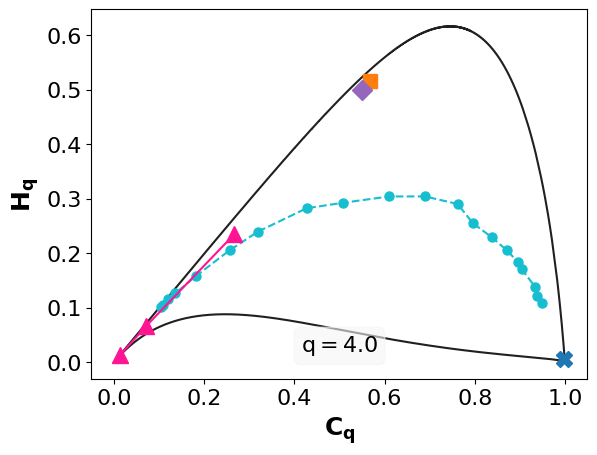

In [5]:
################################################################################
# Plot the Renyi Complexity-Entropy diagrams for each series
################################################################################
# Plot hmin and cmin curves without dashed lines
plt.plot(mapa_RE, mapa_RC, marker='s', markersize=10, color='tab:orange', label='Logistic Map')

# Use dashed lines to connect the points of the other curves

#plt.plot(oscillations_RE, oscillations_RC, '--o', marker='s', markersize=5, markerfacecolor='b', color='b', label='Regular Oscillations')
plt.plot(henon_map_averaged_RE, henon_map_averaged_RC, marker='D', markersize=10, color='tab:purple', label='Hénon Map')

plt.plot(k_noise_E, k_noise_C, '.--',  markersize=13,color='tab:cyan', label='K-noise')
plt.plot(schus_E, schus_C, marker='^', markersize=11, color='deeppink', label='Schuster Map')
plt.plot(white_noise_RE, white_noise_RC, marker='X', markersize=11, color='tab:blue', label='White Noise')
plt.plot(hmin, cmin, linewidth=1.5, color='#202020', zorder=0)#, label='$C_{min}$')
plt.plot(hmax, cmax, linewidth=1.5, color='#202020', zorder=0)#, label='$C_{max}$')

text = f'q$={q}$'#  and  $D={D}$'
# Create the plot
plt.text(0.5, 0.03, text, fontsize=16, ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='whitesmoke', edgecolor='whitesmoke', alpha=0.6))

# Configure Matplotlib so that math labels are not italicized
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

# Configure labels and title with bold font
plt.xlabel(r'$\mathbf{C_q}$', fontsize=18)
plt.ylabel(r'$\mathbf{H_q}$', fontsize=18)

# Increase the size of the axis tick labels
plt.xticks(fontsize=16) # Change the size of the X axis labels
plt.yticks(fontsize=16)  # Change the size of the Y axis labels

# Create the formatted string for the filename
filename = f'/content/renyi_q{q}_D{D}.svg'

# Save the plot with the updated filename
plt.savefig(filename, format='svg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()